# Выбор локации для скважины

**Цель исследования** - Решить, где бурить скважину для добывающей компании «ГлавРосГосНефть»

**Задачи:**

1. Построить модель для определения региона, где добыча принесёт наибольшую прибыль. 
2. Проанализировать возможную прибыль и риски.

**План исследования**
1. Изучить данные;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Корреляционный анализ;
5. Обучение модели;
6. Подготовка к расчету прибыли;
7. Расчет прибыли и рисков;
8. Вывод.

**Согласно документации к данным**

Таблицы `geo_data_0`, `geo_data_1` и `geo_data_2` находятся данные геологоразведки трёх регионов.

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

## Изучение данных
### Импорт библиотек

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

# Импортируем для машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Импортируем сторонние библиотеки
import phik
from phik.report import plot_correlation_matrix

### Функции

In [2]:
def linear_regres(X, y, num_columns, RANDOM_STATE, TEST_SIZE):
    '''
    Функция принимает значение входных признаков, целевого признака,
    название количественных столбцов и константы. Подготавливает 
    данные для машинного обучения и обучает модель линейной регрессии. 
    Выводит метрику оценки модели, то корень  средне квадратичной ошибки, 
    а также среднее значение прогноза, предсказания на валидационной выборке
    и правильные ответы на валидационной выборке

    '''

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    scaler = StandardScaler()

    X_train_scaler = scaler.fit_transform(X_train[num_columns])
    X_valid_scaler = scaler.transform(X_valid[num_columns])

    X_train = pd.DataFrame(X_train_scaler, columns=num_columns)
    X_valid = pd.DataFrame(X_valid_scaler, columns=num_columns)

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    predictions = model_lr.predict(X_valid)
    rmse = mean_squared_error(y_valid, predictions, squared=False)

    # Проверка модели на адекватность
    model_dr = DummyRegressor(strategy='mean')
    model_dr.fit(X_train, y_train)
    predictions_dr = model_dr.predict(X_valid)
    rmse_dr = mean_squared_error(y_valid, predictions_dr, squared=False)

    print('Корень среднеквадратичной ошибки дамми модели =', rmse_dr, end='\n\n')
    print('Корень среднеквадратичной ошибки =', rmse)
    print('Средний запаз предсказаного сырья =', predictions.mean())

    return model_lr, predictions, y_valid

In [3]:
def volume_vs_mean(product, sufficient_volume):
    '''
    Функция сравнивает безубыточный объем со средним 
    запасом сырья в каждом регионе. На вход получает
    среднее значение реального объема и безубыточный объем. 
    Для расчета используется константа
    
    '''

    if product >= sufficient_volume:
        print('Разработка безубыточная')
    else:
        print('Разработка убыточная\nУбыток =',
              (sufficient_volume - product) * PRICE_BARREL)

In [4]:
def calculation_profit(predictions, real_values):
    '''
    Функция расчитывает прибыль по 200 лучшим предсказаным 
    точкам. На вход получает реальные значения и предсказания 
    модели. Для расчета используются три константы.
    
    '''

    predict_sort = predictions.sort_values(ascending=False)
    select_points = real_values[predict_sort.index][:BEST_POINTS]

    return select_points.sum() * PRICE_BARREL - BUDGET

In [5]:
def bootstrap(predictions, real_values):
    '''
    Функция для использования техники bootstrap
    для расчета средней прибыли, 95%-го доверительного
    интервала рисков убытков и ROI. На вход получает 
    предсказания модели и реальные значения. Для расчета 
    используются три константы и функция для расчета прибыли.

    '''

    real_values = real_values.reset_index(drop=True)
    predictions = pd.Series(predictions)

    values = []
    for i in range(1000):
        pred_subsample = predictions.sample(
            n=EXPLORED_POINTS, replace=True, random_state=STATE)
        real_subsample = real_values[pred_subsample.index]
        values.append(calculation_profit(pred_subsample, real_subsample))

    values = pd.Series(values)

    conf_int = st.norm.interval(
        0.95, loc=np.mean(values), scale=st.sem(values))
    roi = (np.mean(values) - BUDGET) / BUDGET

    print(f'Средняя выручка: {np.mean(values):.2f}')
    print('Доверительный интервал =', conf_int)
    print(f'Риск убытков = {sum(values < 0) / sum(values > 0):.0%}')
    print(f'Возврат на инвестиции = {roi:.0%}')

Смотри, при подсчете через scipy используется распределение Стьюдента. Ты оцениваешь для него параметры и берешь квантили по нему. В нашем же случае у тебя есть "истинное" распределение. Зачем от истинного переходить к его оценке, чтобы по оценке посмотреть на квантили, если мы сразу можем взять квантили.

### Константы

In [6]:
# Задаем константы для деления датасета
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Константы для расчета прибыли
BUDGET = 10_000_000_000
PRICE_BARREL = 450000
EXPLORED_POINTS = 500
BEST_POINTS = 200
STATE = np.random.RandomState(12345)

### Загрузка данных и их изучение

In [7]:
pth0 = r"C:\Users\stepa\Downloads\geo_data_0.csv"
pth1 = r"C:\Users\stepa\Downloads\geo_data_1.csv"
pth2 = r"C:\Users\stepa\Downloads\geo_data_2.csv"

In [8]:
if os.path.exists(pth0):
    geo_data_0 = pd.read_csv(pth0)
else:
    print('Ошибка')

In [9]:
if os.path.exists(pth1):
    geo_data_1 = pd.read_csv(pth1)
else:
    print('Ошибка')

In [10]:
if os.path.exists(pth2):
    geo_data_2 = pd.read_csv(pth2)
else:
    print('Ошибка')

Выведем первые 5 строк всех таблиц

In [11]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [12]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [13]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Посмотрим на общую информацию о данных в таблицах

In [14]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [15]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Рассмотрим полученную информацию подробнее.

Всего в таблице 5 столбцов, тип данных - `object`(1), `float`(4).
Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет.

In [16]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [17]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Рассмотрим полученную информацию подробнее.

Всего в таблице 5 столбцов, тип данных - `object`(1), `float`(4).
Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет.

In [18]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [19]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Рассмотрим полученную информацию подробнее.

Всего в таблице 5 столбцов, тип данных - `object`(1), `float`(4).
Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет.

### Вывод

Каждая сторка таблиц содержит информацию о скважинах. Необходимо сделать проверку данных:

- Cделать проверку на пропуски 
- Сделать проверку на явные и неявные дубликаты.

## Предобработка данных
### Работа с явными дубликатами

Сделаем проверку на явные дубликаты во всех таблицах

In [20]:
geo_data_0.duplicated().sum()

0

In [21]:
geo_data_1.duplicated().sum()

0

In [22]:
geo_data_2.duplicated().sum()

0

### Работа с неявными дубликатами.

Сделаем проверку на неявные дубликаты. В таблицах значения `id` записаны на английском, но некоторые английские буквы совпадают с русскими. И вдруг вместо английских написали русские буквы. Чтобы не проверять каждую букву, удалим столбец `id` и если есть есть неявные дубликаты, то они в таком случае станут явными и будет проведена проврека на явные дубликаты.

Работать будем с копиями таблиц

In [23]:
gd0 = geo_data_0.copy()

In [24]:
gd0 = gd0.drop(columns=['id'], axis=1)

In [25]:
gd0.duplicated().sum()

0

In [26]:
gd1 = geo_data_1.copy()

In [27]:
gd1 = gd1.drop(columns=['id'], axis=1)

In [28]:
gd1.duplicated().sum()

0

In [29]:
gd2 = geo_data_2.copy()

In [30]:
gd2 = gd2.drop(columns=['id'], axis=1)

In [31]:
gd2.duplicated().sum()

0

### Работа с пропусками

Хоть этап изучения данных показал, что пропусков нет, но необходимо в этом удостоверится, поэтому проверим все таблицы на наличие пропусков.

In [32]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [33]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [34]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

В датафреймах пропусков не обнаружено

### Вывод.

На данном этапе были сделаны следующие действия:

1. Сделали проверку на явные дубликаты - **не обнаружены**
2. Сделали проверку на неявные дублика - **не обнаружены**
3. Cделали проверку на пропуски - **не обнаружены**

## Исследовательский анализ данных

Изучим количественные переменные в датафреймах, для этого посмотрим на их распределение. Диаграммы размаха строить не будем, так как, что у нас за признаки не известно и понять являются ли на самом деле значения аномальными не получится.

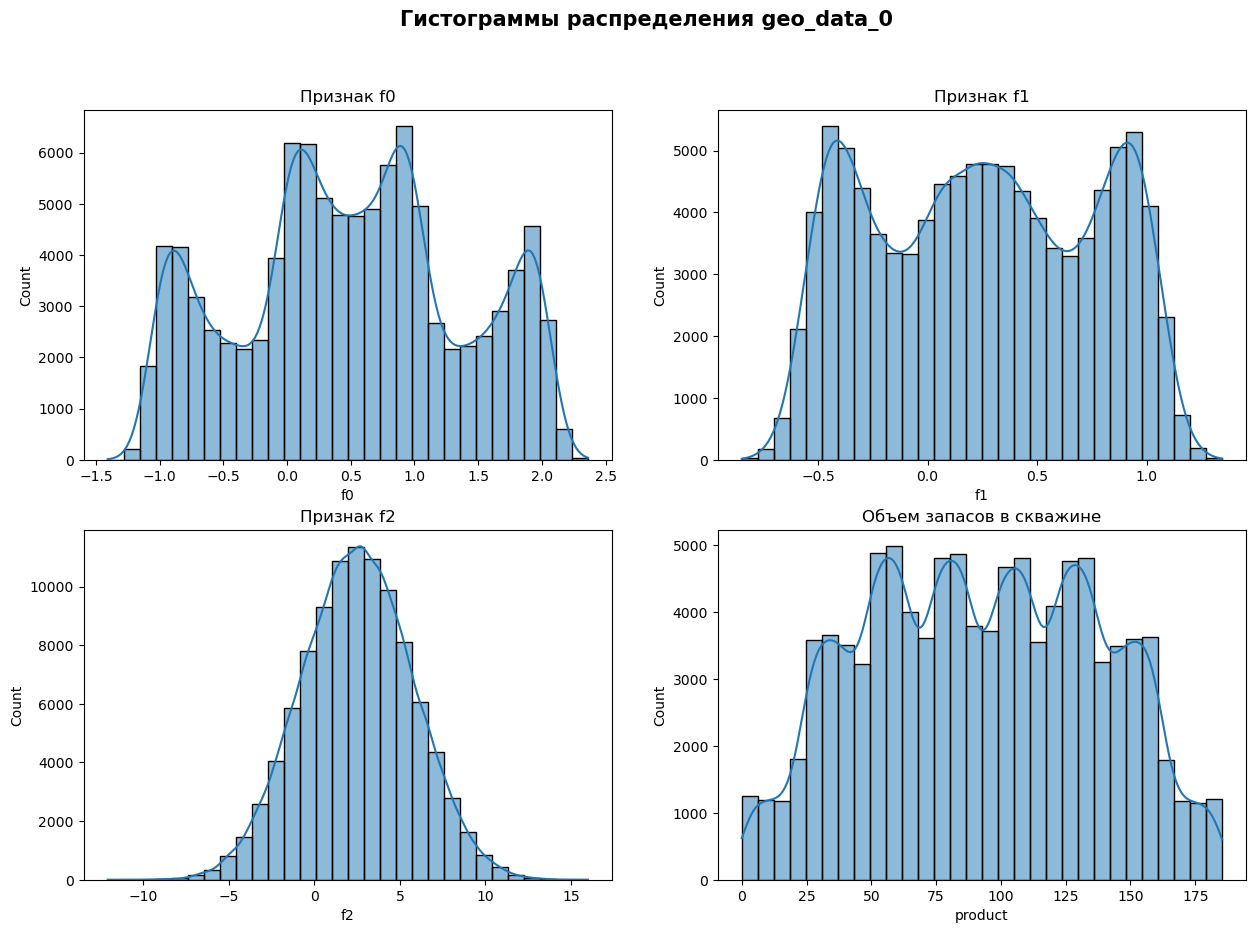

In [35]:
plt.figure(figsize=(15, 10))

plt.suptitle('Гистограммы распределения geo_data_0',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(geo_data_0['f0'], kde=True, bins=30)
plt.title('Признак f0')

plt.subplot(2, 2, 2)
sns.histplot(geo_data_0['f1'], kde=True, bins=30)
plt.title('Признак f1')

plt.subplot(2, 2, 3)
sns.histplot(geo_data_0['f2'], kde=True, bins=30)
plt.title('Признак f2')

plt.subplot(2, 2, 4)
sns.histplot(geo_data_0['product'], kde=True, bins=30)
plt.title('Объем запасов в скважине');

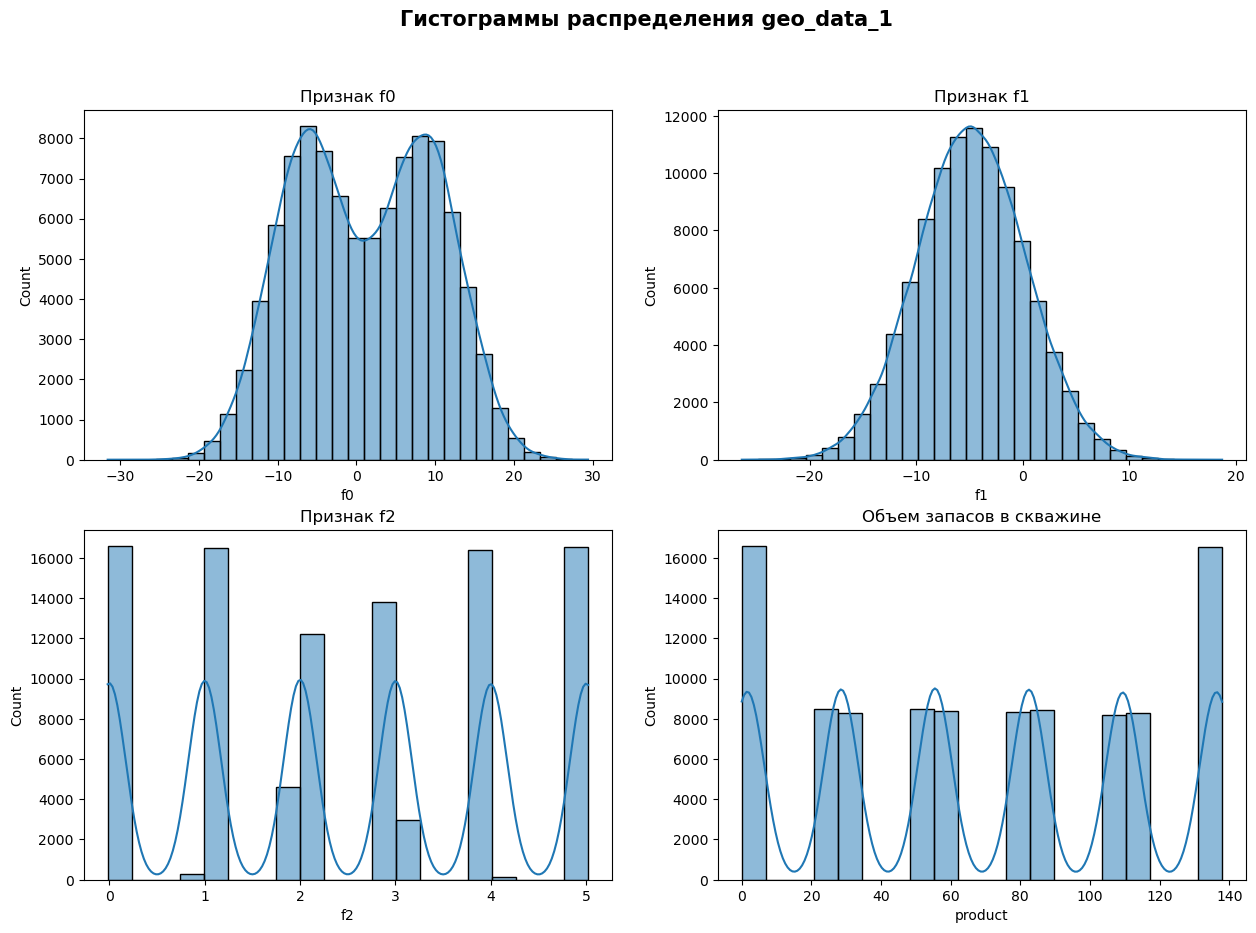

In [36]:
plt.figure(figsize=(15, 10))

plt.suptitle('Гистограммы распределения geo_data_1', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(geo_data_1['f0'], kde=True, bins=30)
plt.title('Признак f0')

plt.subplot(2, 2, 2)
sns.histplot(geo_data_1['f1'], kde=True, bins=30)
plt.title('Признак f1')

plt.subplot(2, 2, 3)
sns.histplot(geo_data_1['f2'], kde=True, bins=20)
plt.title('Признак f2')

plt.subplot(2, 2, 4)
sns.histplot(geo_data_1['product'], kde=True, bins=20)
plt.title('Объем запасов в скважине');

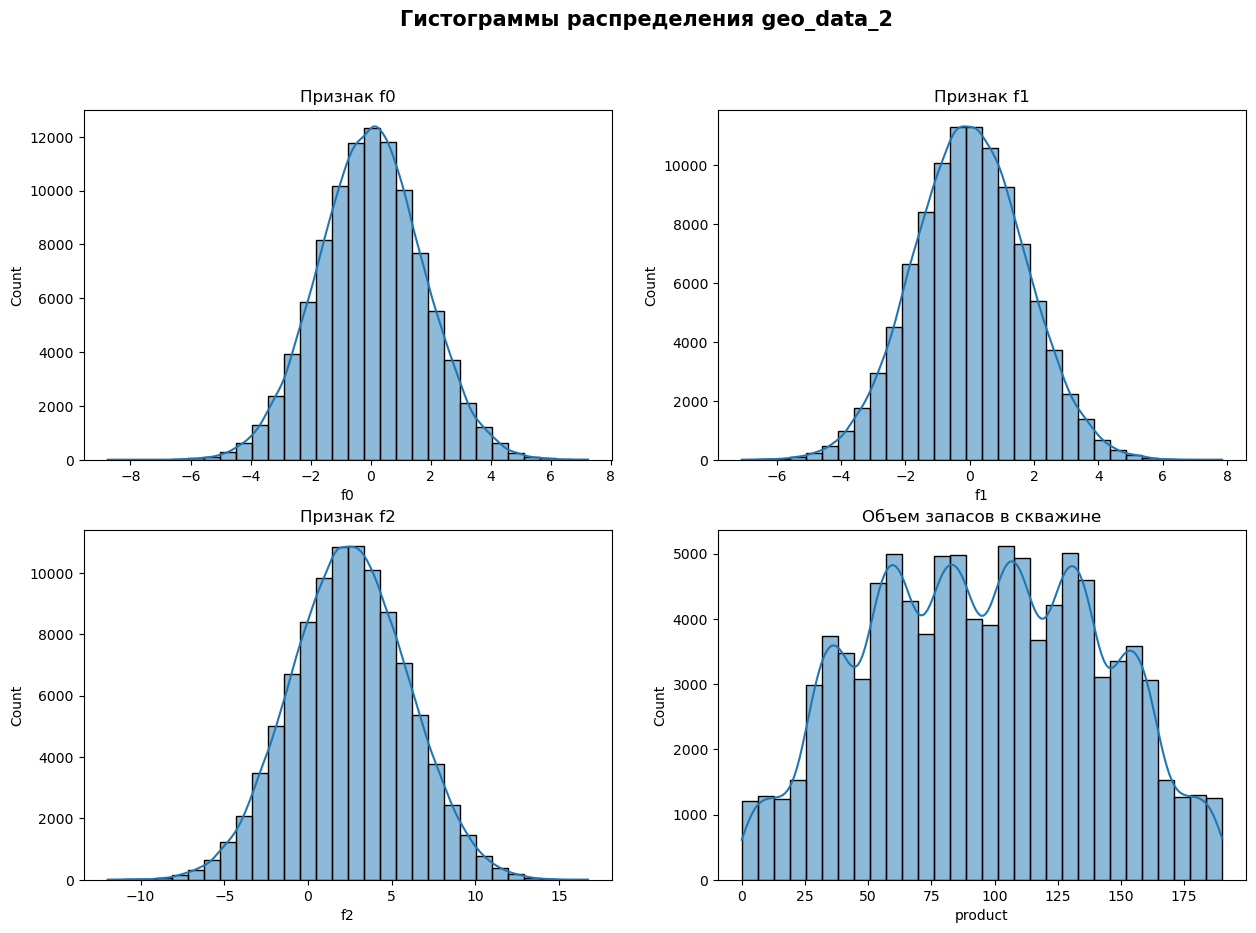

In [37]:
plt.figure(figsize=(15, 10))

plt.suptitle('Гистограммы распределения geo_data_2',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(geo_data_2['f0'], kde=True, bins=30)
plt.title('Признак f0')

plt.subplot(2, 2, 2)
sns.histplot(geo_data_2['f1'], kde=True, bins=30)
plt.title('Признак f1')

plt.subplot(2, 2, 3)
sns.histplot(geo_data_2['f2'], kde=True, bins=30)
plt.title('Признак f2')

plt.subplot(2, 2, 4)
sns.histplot(geo_data_2['product'], kde=True, bins=30)
plt.title('Объем запасов в скважине');

### Вывод

По результатам исследователького анализа можно сделать следующие выводы:

1. В таблице `geo_data_0` только признак `f2` распределен нормально, а остальные распределенны мультимодально.
2. В таблице `geo_data_1` признак `f1` распределен нормально, а признак `f0` имеет два пика.
3. В таблице `geo_data_2` признаки `f0`, `f1` и `f2` распределены нормально, признак `product` мультимодально.

## Корреляционный анализ

Исходя из исследовательского анализа стало понятно, что не все данные в наших датафремах распределены нормально, поэтому для изучения взаимосвязи между переменнами в таблицах необходимо использовать коэффициент корреляции $\phi_k$, он может находить взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

Расчитаем корреляцию при помощи библиотеки $\phi_k$ для всех наших признаков из датафрейма `geo_data_0`.

In [38]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_0 = geo_data_0.drop(columns='id', axis=1).phik_matrix(
    interval_cols=['f0', 'f1', 'f2', 'product'])

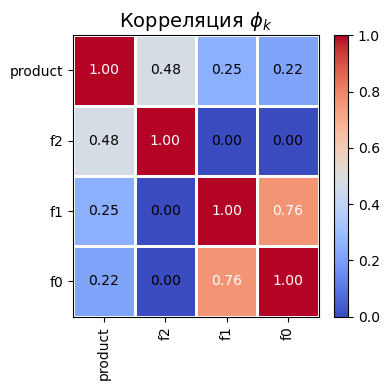

In [39]:
plot_correlation_matrix(phik_matrix_0.values, x_labels=phik_matrix_0.columns, y_labels=phik_matrix_0.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(4, 4))
plt.tight_layout()

Наш целевой признак `product` посмотрим как он взаимодействует с входными признаками.

Есть хорошая взаимосвязь с `f2` - 0.48 и слабая взаимосвязь с `f1` и `f0` - 0.25 и 0.22.

Также изучим все взаимосвязи между признаками.

Признак `f2` не имеет взаимосвязи с `f1` и `f0`.

Признак `f1` имеет взаимосвязь с `f1` - 0.76

Мультиколлинеарность между признаками не наблюдается.

Расчитаем корреляцию при помощи библиотеки $\phi_k$ для всех наших признаков из датафрейма `geo_data_1`.

In [40]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_1 = geo_data_1.drop(columns='id', axis=1).phik_matrix(
    interval_cols=['f0', 'f1', 'f2', 'product'])

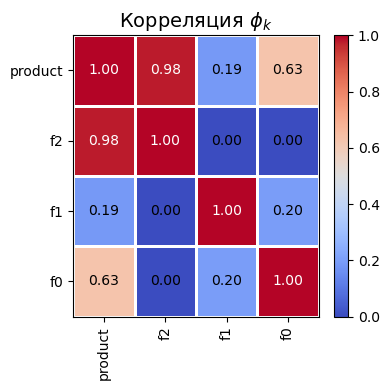

In [41]:
plot_correlation_matrix(phik_matrix_1.values, x_labels=phik_matrix_0.columns, y_labels=phik_matrix_0.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(4, 4))
plt.tight_layout()

Наш целевой признак `product` посмотрим как он взаимодействует с входными признаками.

Есть сильная взаимосвязь с `f2` - 0.98 и хорошая взаимосвязь с `f0` и слабая взаиомсвязь с `f1` - 0.19.

Также изучим все взаимосвязи между признаками.

Признак `f2` не имеет взаимосвязи с `f1` и `f0`.

Признак `f1` имеет взаимосвязь с `f1` - 0.19

Мультиколлинеарность между признаками не наблюдается.

Расчитаем корреляцию при помощи библиотеки $\phi_k$ для всех наших признаков из датафрейма `geo_data_2`.

In [42]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_2 = geo_data_2.drop(columns='id', axis=1).phik_matrix(
    interval_cols=['f0', 'f1', 'f2', 'product'])

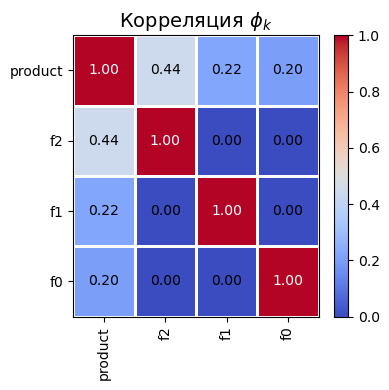

In [43]:
plot_correlation_matrix(phik_matrix_2.values, x_labels=phik_matrix_2.columns, y_labels=phik_matrix_2.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(4, 4))
plt.tight_layout()

Наш целевой признак `product` посмотрим как он взаимодействует с входными признаками.

Есть хорошая взаимосвязь с `f2` - 0.44 и слабая взаимосвязь с `f1` и `f0` - 0.22 и 0.20.

Также изучим все взаимосвязи между признаками.

Признак `f2` не имеет взаимосвязи с `f1` и `f0`.

Признак `f1` имеет взаимосвязь с `f1` - 0.22

Мультиколлинеарность между признаками не наблюдается.

## Обучение и проверка модели

Приступим к обучению модели. Для целового признака `product` воспользуемся линейной регрессией. Разделим выборки на тренировочную и валидационную. Так как у нас только количественные признаки, то будем использовать только стандартизацию `StandardScaler`. Для обучения модели была написана функция `linear_regres`. Оценивать модель будем по среднему запасу предсказанного сырья и RMSE модели.

In [44]:
X = geo_data_0.drop(columns=['id', 'product'], axis=1)
y = geo_data_0['product']

num_columns = ['f0', 'f1', 'f2']

model_lr_0, predictions_0, y_valid_0 = (
    linear_regres(
        X,
        y,
        num_columns,
        RANDOM_STATE,
        TEST_SIZE)
)

Корень среднеквадратичной ошибки дамми модели = 44.27723501700235

Корень среднеквадратичной ошибки = 37.75660035026169
Средний запаз предсказаного сырья = 92.39879990657768


In [45]:
X = geo_data_1.drop(columns=['id', 'product'], axis=1)
y = geo_data_1['product']

num_columns = ['f0', 'f1', 'f2']

model_lr_1, predictions_1, y_valid_1 = (
    linear_regres(
        X,
        y,
        num_columns,
        RANDOM_STATE,
        TEST_SIZE)
)

Корень среднеквадратичной ошибки дамми модели = 45.94485941764291

Корень среднеквадратичной ошибки = 0.8902801001028842
Средний запаз предсказаного сырья = 68.7128780391376


In [46]:
X = geo_data_2.drop(columns=['id', 'product'], axis=1)
y = geo_data_2['product']

num_columns = ['f0', 'f1', 'f2']

model_lr_2, predictions_2, y_valid_2 = (
    linear_regres(
        X,
        y,
        num_columns,
        RANDOM_STATE,
        TEST_SIZE)
)

Корень среднеквадратичной ошибки дамми модели = 44.78277680055413

Корень среднеквадратичной ошибки = 40.145872311342174
Средний запаз предсказаного сырья = 94.77102387765939


### Вывод

Исходя из обучения можно сделать следующие выводы по регионам:

По первому региону:
- `RMSE` показывает, что в среднем на `37.75 тыс. баррелей` предсказания отличаются от истиного значения
- Средний запас предсказанного сырья `92.39 тыс. баррелей`

По второму региону:
- `RMSE` показывает, что в среднем на `0.89 тыс. баррелей` предсказания отличаются от истиного значения
- Средний запас предсказанного сырья `68.71 тыс. баррелей`

По третьему региону:
- `RMSE` показывает, что в среднем на `40.14 тыс. баррелей` предсказания отличаются от истиного значения
- Средний запас предсказанного сырья `94.77 тыс. баррелей`

Все модели прошли проверку на адекватность.

Результаты `RMSE` по второму региону можно объяснить тем, что между целевым признаком и `f1` есть сильная взаимосвязь, что может о говорить о качетсвенных данных и поэтому модель лучше работает.


<div class="alert alert-block alert-success">
<b>Успех:</b> Шаг проделан лаконично, все метрики посчитаны корректно
</div> 

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе 10 млрд. рублей. Цена за 1 баррель 450 рублей. В таблицах объем указан в тысячах баррелей, а следовательно доход с каждой 1 составляет 450000 рублей.

Чтобы не было убытка необходимо расчитать достаточный объем сырья для одной скважины. Для этого необходимо разделить весь бюджет на доход и полученное число поделить на количество скважин (200)

In [47]:
sufficient_volume = BUDGET / PRICE_BARREL / BEST_POINTS
sufficient_volume

111.11111111111111

При условии, что будет потрачен весь бюджет на разработку скважин. Для безубыточной разработки необходимо, чтобы в одной скважине было `112 тыс. баррелей`. Сравним достаточный объем со средним запасом в каждом регионе. Для этого написана функция `volume_vs_mean`, которая сравнивает достаточный объем со средним запасом в каждом регионе. По условию исследуем 500 точек, поэтому для расчета среднего возьмем 500 лучших точек.  

In [48]:
volume_vs_mean(y_valid_0
               .sort_values(ascending=False)
               [:EXPLORED_POINTS].mean(),
               sufficient_volume)

Разработка безубыточная


In [49]:
volume_vs_mean(y_valid_1
               .sort_values(ascending=False)
               [:EXPLORED_POINTS].mean(),
               sufficient_volume)

Разработка безубыточная


In [50]:
volume_vs_mean(y_valid_2
               .sort_values(ascending=False)
               [:EXPLORED_POINTS].mean(),
               sufficient_volume)

Разработка безубыточная


**Вывод**

Входе подготовки к расчету прибыли, рассчитали необходимый безубыточный объем и сравнили его со **средним** значением запаса сырья. Исследовали 500 точек и взяли их среднее. В результе исходя из того, что берем среднее значение и что весь бюджет будет задействован. В среденем все три региона безубыточны

Рассчитаем прибыль по 200 лучшим точкам в каждом регионе. Для этого была написана функция `calculation_profit`. 

In [51]:
calculation_profit(pd.Series(predictions_0), y_valid_0.reset_index(drop=True))

3359141114.462179

In [52]:
calculation_profit(pd.Series(predictions_1), y_valid_1.reset_index(drop=True))

2415086696.681511

In [53]:
calculation_profit(pd.Series(predictions_2), y_valid_2.reset_index(drop=True))

2598571759.374111

**Вывод**

Исходя из того, что выбрали самые лучшие точки, то самый прибыльный регион в этом случаем первый, то есть `geo_data_0`, но также стоит учитывать, тот факт, что самый точный предсказаный регион это второй, и возможно это повлияет в дальнейшем на окончательный выбор.

## Расчёт прибыли и рисков 

Приступим к расчету прибыли, для этого применим технику `Bootstrap` с 1000 выборок, чтобы найти распредление прибыли. По условию задачи исследуют 500 точек и из них выбираются 200 лучших. Также необходимо найти среднюю прибыль и 95%-й доверительный. Для этого была написана функция `bootstrap`, которая принимает на вход предсказания модели.

Для доверительного интервала будем использовать `st.norm.interval`, так как мы имеем дело с большой выборкой, мы предполагаем, что выборочное распредлеение выборочного среднего нормально распределено, беря за основу центральную предельную теорему.

In [54]:
bootstrap(predictions_0, y_valid_0)

Средняя выручка: 435933772.14
Доверительный интервал = (418781909.44463146, 453085634.83269274)
Риск убытков = 6%
Возврат на инвестиции = -96%


Для первого региона `geo_data_0` существует только 5% вероятность того, что истинная средняя выручка меньше 418781909 рублей или больше 453085634 рублей.

Риски убытков - 6%. ROI = -96%, то есть 96% процент прибыли не окупится в самом начале.

In [55]:
bootstrap(predictions_1, y_valid_1)

Средняя выручка: 498569016.92
Доверительный интервал = (485292695.8987885, 511845337.93478817)
Риск убытков = 1%
Возврат на инвестиции = -95%


Для второго региона `geo_data_1` существует только 5% вероятность того, что истинная средняя выручка меньше 485292695 рублей или больше 511845337 рублей.

Риски убытков - 1%. ROI = -95%, то есть 95% процент прибыли не окупится в самом начале.

In [56]:
bootstrap(predictions_2, y_valid_2)

Средняя выручка: 412672898.99
Доверительный интервал = (394920802.6085457, 430424995.3685182)
Риск убытков = 8%
Возврат на инвестиции = -96%


Для третьего региона `geo_data_2` существует только 5% вероятность того, что истинная средняя выручка меньше 394920802 рублей или больше 430424995 рублей.

Риски убытков - 8%. ROI = -96%, то есть 96% процент прибыли не окупится в самом начале.

### Вывод

В результате получили следующее:

По первому региону:
- Средняя выручка: 435933772 рублей
- Доверительный интервал = (418781909, 453085634)
- Риск убытков = 6%
- Возврат на инвестиции = -96%

По второму региону:
- Средняя выручка: 498569016 рублей
- Доверительный интервал = (485292695, 511845337)
- Риск убытков = 1%
- Возврат на инвестиции = -95%

По третьему региону:
- Средняя выручка: 412672898 рублей
- Доверительный интервал = (394920802, 430424995)
- Риск убытков = 8%
- Возврат на инвестиции = -96%

Делаем выбор в пользу второго региона у него показатели самые лучшие.

## Вывод

Данные были получены из трех файлов:

- `geo_data_0`;
- `geo_data_1`;
- `geo_data_2`.

Сначала был сделан обзор данных. Само исследование проходило в 5 этапов:

1. Подготовка данных;
    - Обзор данных;
    - Предобработка данных;
    - Исследовательский анализ данных;
    - Корреляционный анализ.
2. Обучение модели;
3. Подготовка к расчету прибыли;
4. Расчет прибыли и рисков;
5. Вывод.

**1 Подготовка данных.**
**1.1 Обзор данных.**

Во всех таблицах 5 столбцов, тип данных - `object`(1), `float`(4).
Пропусков нет. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет.

**1.2 Предобработка данных.**

1. Сделали проверку на явные дубликаты - **не обнаружены**
2. Сделали проверку на неявные дублика - **не обнаружены**
3. Cделали проверку на пропуски - **не обнаружены**

**1.3 Исследовательский анализ данных.**

Так как в данных были только количественные признаки и что у нас за признаки не известно, то смотрели только на то как они распределены.

1. В таблице `geo_data_0` только признак `f2` распределен нормально, а остальные распределенны мультимодально.
2. В таблице `geo_data_1` признак `f1` распределен нормально, а признак `f0` имеет два пика.
3. В таблице `geo_data_2` признаки `f0`, `f1` и `f2` распределены нормально, признак `product` мультимодально.

**1.4 Корреляционный анализ.**

Так как большинство данных распределены ненормальное, то использовали корреляцию $\phi_k$. Наш целевой признак `product`

Результаты для `geo_data_0`:

Целевой признак следующим образом взаимодействует с входными признаками:

- Есть хорошая взаимосвязь с `f2` - 0.48 
- Слабая взаимосвязь с `f1` и `f0` - 0.25 и 0.22.

Входные признаки взаимодействую между собой следующим образом:

- Признак `f2` не имеет взаимосвязи с `f1` и `f0`.
- Признак `f1` имеет взаимосвязь с `f1` - 0.76

Мультиколлинеарность между признаками не наблюдается.

Результаты для `geo_data_1`:

Целевой признак следующим образом взаимодействует с входными признаками:

- Есть сильная взаимосвязь с `f2` - 0.98
- Хорошая взаимосвязь с `f0` 
- Слабая взаиомсвязь с `f1` - 0.19.

Входные признаки взаимодействую между собой следующим образом:

- Признак `f2` не имеет взаимосвязи с `f1` и `f0`.
- Признак `f1` имеет взаимосвязь с `f1` - 0.19

Мультиколлинеарность между признаками не наблюдается.

Результаты для `geo_data_2`:

Целевой признак следующим образом взаимодействует с входными признаками:

- Есть хорошая взаимосвязь с `f2` - 0.44 
- Cлабая взаимосвязь с `f1` и `f0` - 0.22 и 0.20.

Входные признаки взаимодействую между собой следующим образом:

- Признак `f2` не имеет взаимосвязи с `f1` и `f0`.
- Признак `f1` имеет взаимосвязь с `f1` - 0.22

Мультиколлинеарность между признаками не наблюдается.

**2. Обучение модели.**

Необходимо было оучить модель, чтобы она могла предсказать наш целевой признак `product`. Для этого воспользовались линейной регрессией. И написали для обучения модели функцию `linear_regres`. Оценивали модель по среднему запасу предсказанного сырья и RMSE модели. А также была проведена проверка на адектваность модели

По первому региону:
- `RMSE` показывает, что в среднем на `37.75 тыс. баррелей` предсказания отличаются от истиного значения
- Средний запас предсказанного сырья `92.39 тыс. баррелей`

По второму региону:
- `RMSE` показывает, что в среднем на `0.89 тыс. баррелей` предсказания отличаются от истиного значения
- Средний запас предсказанного сырья `68.71 тыс. баррелей`

По третьему региону:
- `RMSE` показывает, что в среднем на `40.14 тыс. баррелей` предсказания отличаются от истиного значения
- Средний запас предсказанного сырья `94.77 тыс. баррелей`

Все модели прошли проверку на адекватность.

**3. Подготовка к расчету прибыли.**

Рассчитали достаточный объем сырья для одной скважины, чтобы разработка месторождения была безубыточная. Для этого разделили весь бюджет на доход и получившиеся число разделили на количество скважин (200). В результате получили, что при условии, что будет потрачен весь бюджет на разработку скважин. Для безубыточной разработки необходимо, чтобы в одной скважине было `112 тыс. баррелей`.

После этого сравнили достаточный объем со средним запасом в каждом регионе. Для этого написали функцию `volume_vs_mean`. В результе исходя из того, что берем среднее значение и что весь бюджет будет задействован. В среденем все три региона безубыточны.

Далее рассчитали прибыль по 200 лучшим точкам в каждом регионе. Для этого написали функцию `calculation_profit`. В результате, исходя из того, что выбрали самые лучшие точки, то самый прибыльный регион в этом случаем первый, то есть `geo_data_0`.

**4. Расчет прибыли и рисков.**

Для расчета прибыли использовали технику `Bootstrap` с 1000 выборок. Исходя из условия задачи брали 500 точек и из них выбирали 200 лучших. Нашли среднюю прибыль, 95%-й доверительный интервал, риск убыток и ROI. Для этого написали функцию `bootstrap`.

Для доверительного интервала использовали `st.norm.interval`, так как мы имеем дело с большой выборкой, мы предполагаем, что выборочное распредлеение выборочного среднего нормально распределено, беря за основу центральную предельную теорему.

По первому региону:
- Средняя выручка: 435933772 рублей
- Доверительный интервал = (418781909, 453085634)
- Риск убытков = 6%
- Возврат на инвестиции = -96%

По второму региону:
- Средняя выручка: 498569016 рублей
- Доверительный интервал = (485292695, 511845337)
- Риск убытков = 1%
- Возврат на инвестиции = -95%

По третьему региону:
- Средняя выручка: 412672898 рублей
- Доверительный интервал = (394920802, 430424995)
- Риск убытков = 8%
- Возврат на инвестиции = -96%

**Вывод.**

Исходя из расчетов можно предложить второй регион `geo_data_1` для разработки месторождения. Так как у него наименьший риск убытков (1%) по сравнению с другими регионами (6% и 7%). Также учитывали ROI, то есть возврат инвестиций и у второго региона возврат инвестиций больше всех, хоть он и отрицательный. Также у него самый большой доверительный интервал. А также в пользу второго региона говорит то, что у него получилась самая точная модель, так как были качественные данные, высокая корреляция одного входного признака с целевым.